In [1]:
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
IMAGE_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
DATA_DIR = r"C:\\Users\\USER\\OneDrive\\Documents\\capstone1\\data\\PlantVillage"

full_dataset = datasets.ImageFolder(
    root=DATA_DIR,
    transform=train_transforms
)

class_names = full_dataset.classes
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("Classes:", class_names)


Number of classes: 16
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy', 'Unidentified']


In [8]:
total_size = len(full_dataset)

train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size]
)


In [9]:
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms


In [10]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


In [11]:
images, labels = next(iter(train_loader))
print(images.shape)   # [B, 3, 224, 224]
print(labels.shape)


torch.Size([32, 3, 224, 224])
torch.Size([32])


In [13]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [15]:
model = models.efficientnet_b0(pretrained=True)


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:04<00:00, 5.00MB/s]


In [16]:
for param in model.parameters():
    param.requires_grad = False


In [17]:
in_features = model.classifier[1].in_features

model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512, num_classes)
)

model = model.to(device)


In [18]:
criterion = nn.CrossEntropyLoss()


In [20]:
optimizer = optim.Adam(
    model.classifier.parameters(),
    lr=1e-3
)


In [22]:
from tqdm import tqdm

def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total


In [23]:
def evaluate(model, loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total


In [24]:
EPOCHS = 10

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


100%|██████████| 462/462 [24:14<00:00,  3.15s/it]


Epoch 1/10 | Train Loss: 0.5552, Train Acc: 0.8299 | Val Loss: 0.2338, Val Acc: 0.9267


100%|██████████| 462/462 [28:38<00:00,  3.72s/it]


Epoch 2/10 | Train Loss: 0.2672, Train Acc: 0.9127 | Val Loss: 0.1655, Val Acc: 0.9450


100%|██████████| 462/462 [29:31<00:00,  3.83s/it]


Epoch 3/10 | Train Loss: 0.2028, Train Acc: 0.9311 | Val Loss: 0.1689, Val Acc: 0.9488


100%|██████████| 462/462 [25:59<00:00,  3.38s/it]  


Epoch 4/10 | Train Loss: 0.1694, Train Acc: 0.9414 | Val Loss: 0.1273, Val Acc: 0.9548


100%|██████████| 462/462 [23:43<00:00,  3.08s/it] 


Epoch 5/10 | Train Loss: 0.1539, Train Acc: 0.9482 | Val Loss: 0.1094, Val Acc: 0.9624


100%|██████████| 462/462 [20:49<00:00,  2.70s/it]


Epoch 6/10 | Train Loss: 0.1407, Train Acc: 0.9495 | Val Loss: 0.1030, Val Acc: 0.9614


100%|██████████| 462/462 [20:03<00:00,  2.60s/it]


Epoch 7/10 | Train Loss: 0.1285, Train Acc: 0.9555 | Val Loss: 0.1337, Val Acc: 0.9608


100%|██████████| 462/462 [20:33<00:00,  2.67s/it]


Epoch 8/10 | Train Loss: 0.1117, Train Acc: 0.9607 | Val Loss: 0.0968, Val Acc: 0.9652


100%|██████████| 462/462 [28:19<00:00,  3.68s/it] 


Epoch 9/10 | Train Loss: 0.1064, Train Acc: 0.9629 | Val Loss: 0.1164, Val Acc: 0.9637


100%|██████████| 462/462 [23:48<00:00,  3.09s/it]


Epoch 10/10 | Train Loss: 0.1033, Train Acc: 0.9642 | Val Loss: 0.1182, Val Acc: 0.9646


In [26]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "class_names": class_names
    },
    "models/plant_disease_classifier.pth"
)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


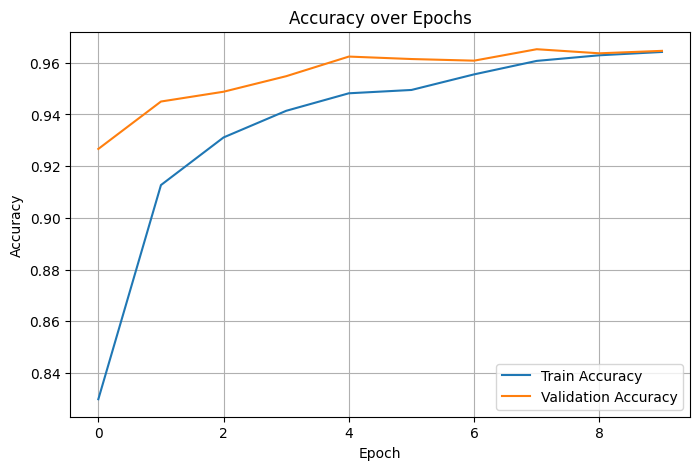

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()


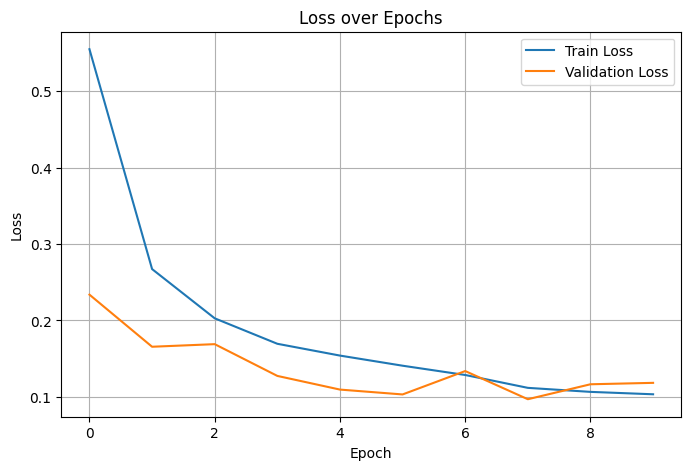

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
y_true = []
y_pred = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())


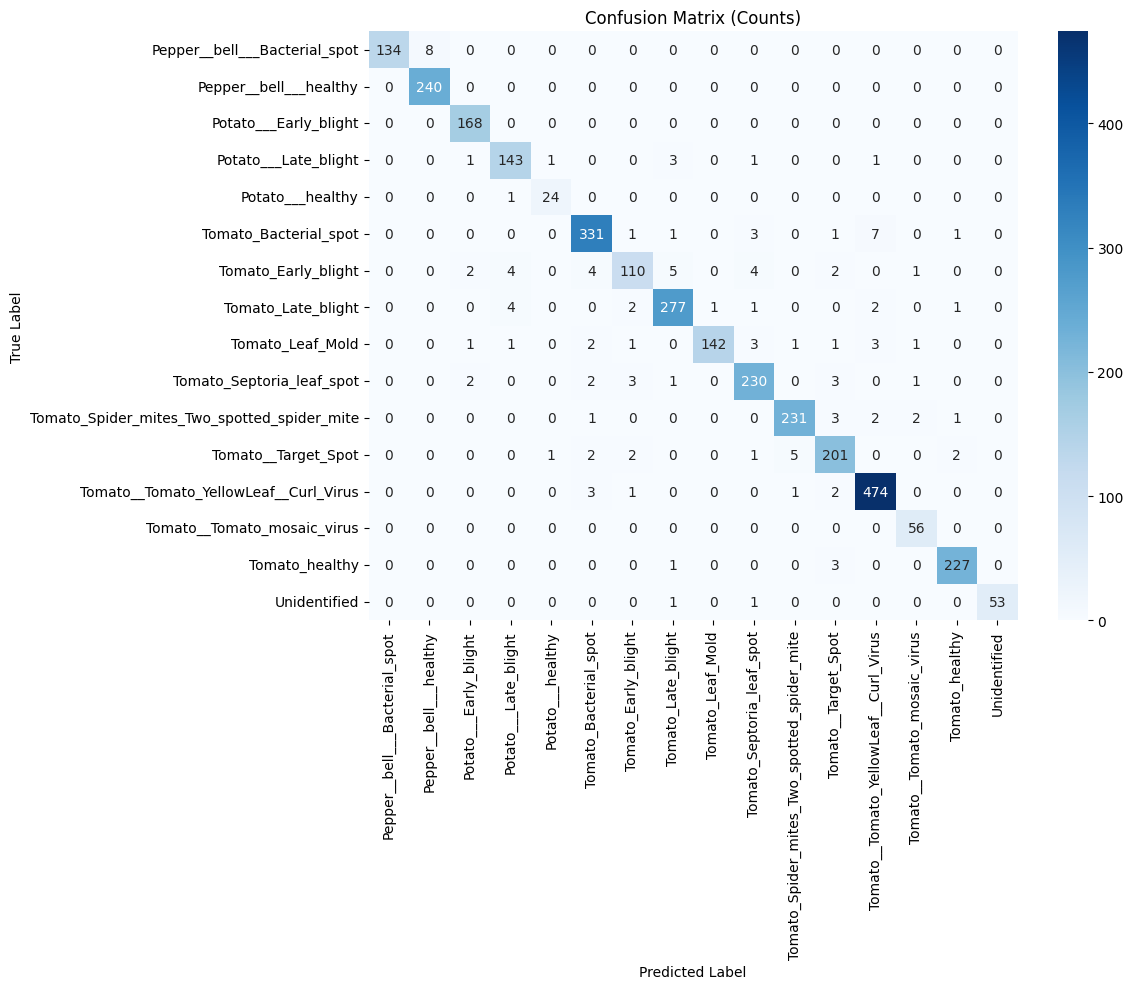

In [33]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,          
    fmt="d",             
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Counts)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [32]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=class_names
    )
)


                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.94      0.97       142
                     Pepper__bell___healthy       0.97      1.00      0.98       240
                      Potato___Early_blight       0.97      1.00      0.98       168
                       Potato___Late_blight       0.93      0.95      0.94       150
                           Potato___healthy       0.92      0.96      0.94        25
                      Tomato_Bacterial_spot       0.96      0.96      0.96       345
                        Tomato_Early_blight       0.92      0.83      0.87       132
                         Tomato_Late_blight       0.96      0.96      0.96       288
                           Tomato_Leaf_Mold       0.99      0.91      0.95       156
                  Tomato_Septoria_leaf_spot       0.94      0.95      0.95       242
Tomato_Spider_mites_Two_spotted_spider_mite       0.97      0.96